In [1]:
import os,sys
import pandas as pd
# # Add the project root to sys.path
# import modules_content_filter.Content_Filtering
# import modules_content_filter.Post_cleaning_Content_Filter
import modules_content_filter

# print(sys.path)
class DataProcessor:
    def __init__(self):
        self.data_path = '/home/gm/Desktop/ExcelR_Projects/book_recommendation/preprocessed_data/book_details_bart.csv'
        self.cleaning_module = modules_content_filter.Cleaning_content_filter.cleaning_dirty_data()     
        self.content_filtering = modules_content_filter.Content_Filtering
        self.pickle_or_no = False

    def process_data(self):
        # Load data
        df = self.load_data()

        # Clean data
        cleaned_df = self.word_embed_cleaning(df)
        cleaned_df.to_csv('cleaned_data_ConB.csv',index=False)

        # Process data (e.g., word embedding)
        processed_data = self.process(cleaned_df)

        return processed_data

    def load_data(self):
        # Implement logic to load data from self.data_path
        df = pd.read_csv(self.data_path)
        df = df[~df.book_details.isna()]
        # print(len(df))
        return df

    def process(self, df):
        # Implement data processing logic using the Content_based_filtering module
        # processed_data = self.content_filtering.ContentBasedRecommender(df)

        recommender = self.content_filtering.ContentBasedRecommender(df)
        param_grid_doc = {'vector_size': [100, 200], 'min_count': [1, 5], 'epochs': [10, 20]}
        param_grid_word={'vector_size': [100,200], 'window': [1, 5], 'min_count': [1], 'workers': [4]}
        best_params_word, best_score_word=recommender.tune_word2vec(param_grid_word)
        best_params_doc, best_score_doc=recommender.tune_doc2vec(param_grid_doc)

        # Get recommendations for the first book
        recommender=self.content_filtering.ContentBasedRecommender(df,word2vec_params=best_params_word,doc2vec_params=best_params_doc,pickle_save=self.pickle_or_no)
        recommendations = recommender.get_recommendations_for_book(book_title='The Amityville Horror', top_n=5)
        # print(recommendations)

        return recommendations

    def word_embed_cleaning(self,df):
        index_to_remove=set()
        cols=['author','book_title','book_details','Genre_Interpretation']
        for c in cols:
            a=df[c].apply(self.cleaning_module.text_cleaning)
            for i,v in a.items():
                if len(v)==0:
                    index_to_remove.add(i)

        df.drop(index_to_remove,inplace=True)
        df.reset_index(inplace=True,drop=True)
        return df
    
    @property
    def Pickle_or_no_pickle(self):
        return self.pickle_or_no
    
    @Pickle_or_no_pickle.setter
    def Pickle_or_no_pickle(self,value):
        self.pickle_or_no = value


if __name__ == "__main__":
    import argparse

    # parser = argparse.ArgumentParser(description="Data Processing")
    # parser.add_argument("--data_path", type=str, required=True, help="Path to the data file")
    # parser.add_argument("--model_save_path", type=str, required=True, help="Path to save the model")

    # args = parser.parse_args()

    data_processor = DataProcessor()
    data_processor.Pickle_or_no_pickle = True
    processed_data = data_processor.process_data()

    # Save the processed data or model
    # Implement logic to save the processed data or model to args.model_save_path


Training Word2Vec with params: {'min_count': 1, 'vector_size': 100, 'window': 1, 'workers': 4}
Training Word2Vec with params: {'min_count': 1, 'vector_size': 100, 'window': 5, 'workers': 4}
Training Word2Vec with params: {'min_count': 1, 'vector_size': 200, 'window': 1, 'workers': 4}
Training Word2Vec with params: {'min_count': 1, 'vector_size': 200, 'window': 5, 'workers': 4}
Training Doc2Vec with params: {'epochs': 10, 'min_count': 1, 'vector_size': 100}
Training Doc2Vec with params: {'epochs': 10, 'min_count': 1, 'vector_size': 200}
Training Doc2Vec with params: {'epochs': 10, 'min_count': 5, 'vector_size': 100}
Training Doc2Vec with params: {'epochs': 10, 'min_count': 5, 'vector_size': 200}
Training Doc2Vec with params: {'epochs': 20, 'min_count': 1, 'vector_size': 100}
Training Doc2Vec with params: {'epochs': 20, 'min_count': 1, 'vector_size': 200}
Training Doc2Vec with params: {'epochs': 20, 'min_count': 5, 'vector_size': 100}
Training Doc2Vec with params: {'epochs': 20, 'min_cou

In [2]:
processed_data

[('Daughter of the Deep', 0.999882),
 ('The Ghost', 0.99987763),
 ('Seduce Me at Sunrise', 0.9998758),
 ('The Discovery of India', 0.9998736),
 ('The Killer Inside Me', 0.9998683)]

In [5]:
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
# Load the embeddings
book_data=pd.read_csv('cleaned_data_ConB.csv')
def first():
    with open('combined_embeddings.pkl', 'rb') as f:
        combined_embeddings = pickle.load(f)
    combined_embeddings_matrix = np.stack(combined_embeddings.values)
    cosine_similarities = cosine_similarity(combined_embeddings_matrix, combined_embeddings_matrix)
    return cosine_similarities

def get_recommendations_for_book(book_title='', top_n=5):
        # Find the index corresponding to the given book title
        book_index = book_data[book_data['book_title'] == book_title].index[0]
        cosine_similarities = first()
        recommended_books = get_recommendations(book_index, cosine_similarities, top_n)
        return recommended_books

def get_recommendations(book_index, cosine_similarities, top_n=5):
        sim_scores = list(enumerate(cosine_similarities[book_index]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n+1]  # Exclude the book itself
        recommended_books = [(book_data.iloc[i]['book_title'], sim_scores[i][1]) for i in range(len(sim_scores))]
        return recommended_books

In [12]:
get_recommendations_for_book(book_title='The Secret of Dragonhome', top_n=100)

[('Daughter of the Deep', 0.999849),
 ('The Ghost', 0.9998199),
 ('Seduce Me at Sunrise', 0.99981326),
 ('The Discovery of India', 0.9998075),
 ('The Killer Inside Me', 0.99980515),
 ('The Lost Apothecary', 0.9998033),
 ('Night Watch', 0.9998024),
 ('First Step 2 Forever', 0.9998),
 ('Memory and Dream', 0.9997962),
 ('The Honorary Consul', 0.99978954),
 ('Totem and Taboo', 0.9997892),
 ('The Knife of Never Letting Go', 0.99978876),
 ('Breakaway: A Gail McCarthy Mystery', 0.99978477),
 ('The Luminaries', 0.9997792),
 ("Captain Nemo's library", 0.99977905),
 ('A Perfect Spy', 0.999778),
 ('The Amateur Marriage', 0.9997711),
 ('Kitty and the Midnight Hour', 0.9997702),
 ('Fury', 0.9997666),
 ('Garden Spells', 0.9997664),
 ('The Private Patient', 0.99976623),
 ('Founding the Communist International, Proceedings and Documents of the First Congress, March 1919',
  0.99976444),
 ('Tigana', 0.99976337),
 ('The Patience of the Spider', 0.9997608),
 ("The Mote in God's Eye", 0.99975514),
 ('Ghos

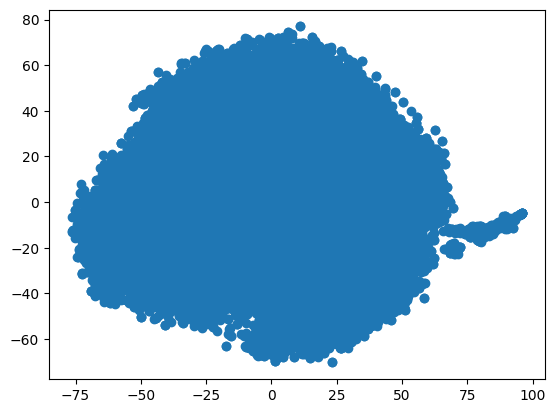

In [35]:
with open('Doc2vec_embeddings.pkl', 'rb') as f:
        combined_embeddings = pickle.load(f)
combined_embeddings_matrix = np.stack(combined_embeddings.values)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(embeddings):
    tsne = TSNE(n_components=2, random_state=0)
    reduced_embeddings = tsne.fit_transform(embeddings)
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
    plt.show()

# Assuming combined_embeddings_matrix is your numpy array of embeddings
visualize_embeddings(combined_embeddings_matrix)

In [5]:
import numpy as np
import pickle
with open('Word2vec_embeddings.pkl', 'rb') as f:
        Word2Vec_embeddings = pickle.load(f)
Word2Vec_embeddings_matrix = np.stack(Word2Vec_embeddings.values)


In [14]:
import pickle
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
# Load the embeddings
book_data=pd.read_csv('cleaned_data_ConB.csv')
def first(doc):
    if doc==False:
        with open('Word2vec_embeddings.pkl', 'rb') as f:
             combined_embeddings = pickle.load(f)
    else:
        with open('Doc2vec_embeddings.pkl', 'rb') as f:
            combined_embeddings = pickle.load(f)
    combined_embeddings_matrix = np.stack(combined_embeddings.values)
    cosine_similarities = cosine_similarity(combined_embeddings_matrix, combined_embeddings_matrix)
    return cosine_similarities

def get_recommendations_for_book(book_title='', top_n=5, doc=False):
        # Find the index corresponding to the given book title
        book_index = book_data[book_data['book_title'] == book_title].index[0]
        cosine_similarities = first(doc)
        recommended_books = get_recommendations(book_index, cosine_similarities, top_n)
        return recommended_books

def get_recommendations(book_index, cosine_similarities, top_n=5):
        sim_scores = list(enumerate(cosine_similarities[book_index]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n+1]  # Exclude the book itself
        recommended_books = [(book_data.iloc[i]['book_title'], sim_scores[i][1]) for i in range(len(sim_scores))]
        return recommended_books

In [33]:
get_recommendations_for_book(book_title='Harry Potter and the Goblet of Fire', top_n=100,doc=True)

[('Daughter of the Deep', 0.9427713),
 ('The Ghost', 0.9383587),
 ('Seduce Me at Sunrise', 0.9378271),
 ('The Discovery of India', 0.9361969),
 ('The Killer Inside Me', 0.9331245),
 ('The Lost Apothecary', 0.92980945),
 ('Night Watch', 0.9292858),
 ('First Step 2 Forever', 0.9271972),
 ('Memory and Dream', 0.92682457),
 ('The Honorary Consul', 0.92667156),
 ('Totem and Taboo', 0.92546344),
 ('The Knife of Never Letting Go', 0.92518103),
 ('Breakaway: A Gail McCarthy Mystery', 0.9250836),
 ('The Luminaries', 0.9240106),
 ("Captain Nemo's library", 0.92386377),
 ('A Perfect Spy', 0.9229984),
 ('The Amateur Marriage', 0.92262125),
 ('Kitty and the Midnight Hour', 0.9222939),
 ('Fury', 0.9221601),
 ('Garden Spells', 0.9211593),
 ('The Private Patient', 0.9210246),
 ('Founding the Communist International, Proceedings and Documents of the First Congress, March 1919',
  0.9208269),
 ('Tigana', 0.92039335),
 ('The Patience of the Spider', 0.92022294),
 ("The Mote in God's Eye", 0.9189805),
 ('

In [22]:
book_data['book_title']

0          Daughter of the Deep
1                     The Ghost
2          Seduce Me at Sunrise
3        The Discovery of India
4          The Killer Inside Me
                  ...          
15451         The Burning Times
15452    The Runes of the Earth
15453     Ten Days in the Hills
15454               The Chemist
15455            The Poe Shadow
Name: book_title, Length: 15456, dtype: object

In [27]:
book_data.sort_values(by='book_id',ascending=True)

,book_id,book_title,book_details,format,author,num_pages,genres,num_ratings,num_reviews,average_rating,5,4,3,2,1,years_since_first_publication,Genre_Interpretation
5422,1,Harry Potter and the Half-Blood Prince,A relationshippy respite itsSturm und Drangde...,Paperback,J.K. Rowling,1.372944,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...",3.143337,2.224686,2.207087,2.551799,2.146515,1.908666,1.790896,1.958853,-0.161048,Fantasy
2898,2,Harry Potter and the Order of the Phoenix,Harry Potter is about to start his fifth year ...,Paperback,J.K. Rowling,2.143859,"['Young Adult', 'Fiction', 'Magic', 'Childrens...",3.167789,2.284863,1.840247,2.539856,2.186602,2.026611,1.947137,2.051118,-0.047099,Juvenile Fiction
14156,3,Harry Potter and the Sorcerer's Stone,Harry Potter has no idea how famous he is. Tha...,Hardcover,J.K. Rowling,-0.086892,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",4.031111,2.890412,1.706873,2.984032,2.592787,2.465490,2.511684,2.958732,0.230250,Juvenile Fiction
11519,5,Harry Potter and the Prisoner of Azkaban,This is the last Harry Potter book in which H...,Mass Market Paperback,J.K. Rowling,0.541129,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",3.330414,2.461384,2.207087,2.654266,2.236927,2.018778,1.843525,2.098680,0.143407,Juvenile Fiction
11042,6,Harry Potter and the Goblet of Fire,A ExtraordinaryNotes A tone transfiguration i...,Paperback,J.K. Rowling,1.636235,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...",3.234863,2.337948,2.160332,2.595410,2.206471,1.976893,1.818830,2.027906,0.098026,Juvenile Fiction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11276,208567667,The Art of Avoiding Your Alpha,Borderline the exact same plot as the first o...,Kindle Edition,Lola Glass,-0.642522,"['Science Fiction Fantasy', 'Fantasy', 'Novels...",-0.898515,-0.999303,-0.072147,-0.805715,-0.788769,-0.719153,-0.873105,-1.144984,-3.386929,Fantasy
5224,208877648,The Descent,"Set in the 1950s, The Descent asks the questio...",Paperback,Fritz Peters,-0.329773,['Fiction'],-2.443362,-2.491640,3.042521,-2.794083,-3.033418,-3.126069,-2.676819,-2.334253,1.341345,Science Fiction and Exploration
5174,209251042,FDR Unmasked: 73 Years of Medical Cover-ups Th...,FDR Unmasked by Steven Lomazow is a well rese...,Paperback,Steven Lomazow,-0.047712,"['Drama', 'Novels', 'Contemporary']",-1.046832,-1.725632,1.073163,-0.869193,-0.869551,-1.626564,-1.174602,-1.116642,-3.348230,Classic Fiction
7351,209441121,Code Yellow in Gretna Green,Code Yellow is a wonderful continuation of Ni...,Kindle Edition,Linzi Day,1.763181,"['Science Fiction Fantasy', 'Fantasy', 'Fictio...",-1.006860,-0.927095,2.348917,-0.672464,-1.063253,-1.358911,-1.991204,-2.029850,-3.426976,Fantasy


        book_id            book_title  \
6200    1754206           Perfect You   
4070   43807935     When She Returned   
5371   18108877             Timebound   
11518  36127456  Listen to Your Heart   
2261    9681214      The Goddess Test   

                                            book_details          format  \
6200   Kate Brown's life has gone downhill fast.Her f...       Paperback   
4070   One woman’s reappearance throws her family int...  Kindle Edition   
5371   When Kate Pierce-Keller’s grandmother gives he...  Kindle Edition   
11518  Talking to other people isn't Kate Bailey's fa...       Hardcover   
2261   Every girl who had taken the test has died.Now...       Paperback   

                author  num_pages  \
6200   Elizabeth Scott  -0.244093   
4070     Lucinda Berry  -0.178832   
5371       Rysa Walker   0.215880   
11518       Kasie West   0.060993   
2261      Aimee Carter  -0.178832   

                                                  genres  num_ratings  \


In [3]:
df[df.book_id==37847]

,book_id,book_title,book_details,format,author,num_pages,genres,num_ratings,num_reviews,average_rating,5,4,3,2,1,years_since_first_publication,Genre_Interpretation,combined_features
2290,37847,The Long Hard Road Out of Hell,"The 150,000-copy national bestselling autobiog...",Paperback,Marilyn Manson,-0.286552,"['Nonfiction', 'Music', 'Biography', 'Memoir',...",0.336007,0.237815,-0.673835,0.382058,0.376341,0.488354,0.661783,0.843029,0.208745,Non Fiction,The Long Hard Road Out of Hell Marilyn Manson ...


In [4]:
recommendations

,book_id,book_title,book_details,format,author,num_pages,genres,num_ratings,num_reviews,average_rating,5,4,3,2,1,years_since_first_publication,Genre_Interpretation,combined_features
6200,1754206,Perfect You,Kate Brown's life has gone downhill fast.Her f...,Paperback,Elizabeth Scott,-0.244093,"['Young Adult', 'Romance', 'Contemporary', 'Ch...",0.180717,0.004098,-1.045356,0.172026,0.222212,0.463757,0.588964,0.566533,-0.328423,Adult/YA Fiction,Perfect You Elizabeth Scott Adult/YA Fiction K...
4070,43807935,When She Returned,One woman’s reappearance throws her family int...,Kindle Edition,Lucinda Berry,-0.178832,"['Thriller', 'Mystery', 'Fiction', 'Mystery Th...",0.752844,0.736103,-0.004556,0.745229,0.799635,0.789742,0.766123,0.707626,-1.613769,Thriller/Mystery,When She Returned Lucinda Berry Thriller/Myste...
5371,18108877,Timebound,When Kate Pierce-Keller’s grandmother gives he...,Kindle Edition,Rysa Walker,0.215880,"['Time Travel', 'Young Adult', 'Science Fictio...",0.319082,0.505515,-0.460505,0.308383,0.461919,0.493408,0.480734,0.457098,-0.675657,Science Fiction and Exploration,Timebound Rysa Walker Science Fiction and Expl...
11518,36127456,Listen to Your Heart,Talking to other people isn't Kate Bailey's fa...,Hardcover,Kasie West,0.060993,"['Romance', 'Young Adult', 'Contemporary', 'Au...",0.130871,0.510318,-0.613853,0.098475,0.292335,0.404447,0.291084,-0.016314,-1.361030,Adult/YA Fiction,Listen to Your Heart Kasie West Adult/YA Ficti...
2261,9681214,The Goddess Test,Every girl who had taken the test has died.Now...,Paperback,Aimee Carter,-0.178832,"['Fantasy', 'Young Adult', 'Mythology', 'Roman...",0.648239,0.862603,-0.762375,0.623444,0.637207,0.766973,0.960661,1.081078,-0.554572,"Supernatural, Mystery, and Romance","The Goddess Test Aimee Carter Supernatural, My..."


In [5]:
sim_scores

[(6189, 0.17719075616138502),
 (4066, 0.17012534503306154),
 (5363, 0.16983359454778224),
 (11493, 0.16205142817826812),
 (2259, 0.1546967867906115)]

,book_id,book_title,book_details,format,author,num_pages,genres,num_ratings,num_reviews,average_rating,5,4,3,2,1,years_since_first_publication,Genre_Interpretation,combined_features
14136,86663,Ten Big Ones,"""I'm Stephanie Plum. My mother says that I'm f...",Mass Market Paperback,Janet Evanovich,-0.031106,"['Mystery', 'Fiction', 'Humor', 'Chick Lit', '...",0.946322,0.472020,0.418816,0.935100,0.955179,0.918452,0.610175,0.303500,-0.101007,Thriller/Mystery,Ten Big Ones Janet Evanovich Thriller/Mystery ...
14143,3130430,"Harry, a History: The True Story of a Boy Wiza...",THE HARRY POTTER BOOKS WERE JUST THE BEGINNING...,Paperback,Melissa Anelli,0.165270,"['Nonfiction', 'Memoir', 'Biography', 'Books A...",0.021618,-0.121586,0.310065,0.259156,-0.007062,0.130823,0.188021,0.312069,-0.370232,Children's and General Literature,"Harry, a History: The True Story of a Boy Wiza..."
14215,133266,Four Past Midnight,At midnight comes the point of balance. Of dan...,Paperback,Stephen King,2.191198,"['Horror', 'Fiction', 'Short Stories', 'Thrill...",0.979879,0.418678,-0.269968,0.857213,0.983949,1.061280,0.902597,0.663696,0.503194,Thriller/Mystery,Four Past Midnight Stephen King Thriller/Myste...
14240,5347,Bleachers,High school All-American Neely Crenshaw was pr...,Paperback,John Grisham,-0.586211,"['Fiction', 'Sports', 'Football', 'Mystery', '...",0.500310,0.455777,-1.460865,0.314112,0.509300,0.795178,0.959910,0.891541,-0.040660,Classic Fiction,Bleachers John Grisham Classic Fiction High sc...
14254,80566,Run,Run shows us how worlds of privilege and pover...,Hardcover,Ann Patchett,-0.167151,"['Fiction', 'Contemporary', 'Literary Fiction'...",0.577646,0.893576,-1.153442,0.335204,0.673563,0.845402,0.867662,0.612208,-0.248938,Classic Fiction,Run Ann Patchett Classic Fiction Run shows us ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15478,300650,On Becoming Baby Wise: Giving Your Infant the ...,"""THIS BOOK HAS NOT BEEN PRINTED IN MORE THAN 1...",Paperback,Gary Ezzo,-0.431606,"['Parenting', 'Nonfiction', 'Self Help', 'Fami...",0.032496,0.429055,-1.072646,0.039703,0.139984,0.233352,0.387985,0.734782,0.398370,Non Fiction,On Becoming Baby Wise: Giving Your Infant the ...
15489,385742,Gregor and the Prophecy of Bane,The action and adventure continue for Gregor i...,Paperback,Suzanne Collins,-0.070025,"['Fantasy', 'Young Adult', 'Middle Grade', 'Fi...",0.549613,0.451484,0.642278,0.654783,0.640963,0.533567,0.238139,0.176440,-0.075280,Juvenile Fiction,Gregor and the Prophecy of Bane Suzanne Collin...
15514,177246,Room on the Broom,This fun family read-aloud i s the perfect way...,Paperback,Julia Donaldson,-2.939718,"['Picture Books', 'Halloween', 'Childrens', 'F...",0.206982,0.198076,1.619205,0.516153,0.176040,0.042915,-0.090707,0.094054,0.044304,Children's and General Literature,Room on the Broom Julia Donaldson Children's a...
15523,12842,Journey to Ixtlan: The Lessons of Don Juan,"In Journey to Ixtlan, Carlos Castaneda introdu...",Paperback,Carlos Castaneda,-0.304980,"['Philosophy', 'Fiction', 'Spirituality', 'Ant...",-0.055685,-0.278105,0.274250,0.135176,0.038977,0.048561,0.060152,0.070793,0.975733,Non Fiction,Journey to Ixtlan: The Lessons of Don Juan Car...


,,12th Century,13th Century,15th Century,16th Century,17th Century,18th Century,19th Century,1st Grade,20th Century,...,X Men,Yaoi,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Historical Fiction,Young Adult Paranormal,Young Adult Romance,Zimbabwe,Zombies
book_id,,,,,,,,,,,,,,,,,,,,,
57094644,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
895185,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2948832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154126,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
298663,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183057601,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
337100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9817,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
book_id,,,,,,,,,,,,,,,,,,,,,
57094644,-0.952030,0.634815,-0.094921,-0.775566,0.039779,0.809178,0.225492,0.199790,0.309688,0.282709,...,-0.107950,-0.027769,-0.085563,0.115064,-0.042672,-0.057796,0.034541,-0.012277,-0.019177,-0.008526
895185,-0.046748,-1.144341,1.160032,-0.136563,0.669057,-0.179035,-0.279788,0.172914,0.126123,0.187195,...,0.056540,-0.109763,-0.157469,0.107423,-0.054737,-0.084278,0.000427,0.091386,0.105652,-0.013235
2948832,-0.238449,-0.233209,-0.330392,0.902859,1.190872,-0.487048,0.375421,-0.319183,0.158373,-0.170558,...,-0.152884,-0.093182,-0.202267,-0.115066,-0.121576,-0.118811,0.015794,-0.078992,-0.059963,-0.004490
154126,1.516022,0.276190,-0.267810,-0.358038,-0.017775,0.074921,-0.328179,-0.455944,-0.070475,0.280320,...,-0.043088,-0.270796,0.041646,0.361355,-0.066165,-0.171691,0.360626,-0.052748,0.036001,0.422290
298663,-0.105523,-1.077319,0.850934,-0.496059,-0.183281,-0.246685,-0.638187,-0.450565,0.198945,-0.297796,...,-0.002426,-0.046234,-0.039658,0.048722,0.013273,0.020989,-0.008186,-0.058932,0.036611,0.028903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183057601,-0.093935,0.954095,0.051908,0.267688,-0.057703,-0.706504,-0.148503,-0.097300,0.020979,-0.008814,...,-0.059957,-0.025157,0.043775,-0.120259,0.135515,-0.016163,-0.049694,0.089257,0.060824,0.111847
337100,-0.679010,0.378917,-0.078807,-0.938678,-0.254778,-0.011969,1.096295,0.065073,0.251759,0.145271,...,-0.039526,-0.063121,-0.008998,0.004066,-0.054904,-0.054521,0.016869,-0.022480,-0.024442,-0.045489
9817,-0.188239,-0.567943,-0.633725,1.088940,-0.768535,-0.114966,-0.047505,0.710976,-0.182096,0.419855,...,-0.016826,0.036132,0.012565,-0.027962,-0.001658,0.046636,-0.015482,0.027645,-0.006489,-0.030363


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
book_id,,,,,,,,,,,,,,,,,,,,,
57094644,-0.952030,0.634815,-0.094921,-0.775566,0.039779,0.809178,0.225492,0.199790,0.309688,0.282709,...,-0.107950,-0.027769,-0.085563,0.115064,-0.042672,-0.057796,0.034541,-0.012277,-0.019177,-0.008526
895185,-0.046748,-1.144341,1.160032,-0.136563,0.669057,-0.179035,-0.279788,0.172914,0.126123,0.187195,...,0.056540,-0.109763,-0.157469,0.107423,-0.054737,-0.084278,0.000427,0.091386,0.105652,-0.013235
2948832,-0.238449,-0.233209,-0.330392,0.902859,1.190872,-0.487048,0.375421,-0.319183,0.158373,-0.170558,...,-0.152884,-0.093182,-0.202267,-0.115066,-0.121576,-0.118811,0.015794,-0.078992,-0.059963,-0.004490
154126,1.516022,0.276190,-0.267810,-0.358038,-0.017775,0.074921,-0.328179,-0.455944,-0.070475,0.280320,...,-0.043088,-0.270796,0.041646,0.361355,-0.066165,-0.171691,0.360626,-0.052748,0.036001,0.422290
298663,-0.105523,-1.077319,0.850934,-0.496059,-0.183281,-0.246685,-0.638187,-0.450565,0.198945,-0.297796,...,-0.002426,-0.046234,-0.039658,0.048722,0.013273,0.020989,-0.008186,-0.058932,0.036611,0.028903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183057601,-0.093935,0.954095,0.051908,0.267688,-0.057703,-0.706504,-0.148503,-0.097300,0.020979,-0.008814,...,-0.059957,-0.025157,0.043775,-0.120259,0.135515,-0.016163,-0.049694,0.089257,0.060824,0.111847
337100,-0.679010,0.378917,-0.078807,-0.938678,-0.254778,-0.011969,1.096295,0.065073,0.251759,0.145271,...,-0.039526,-0.063121,-0.008998,0.004066,-0.054904,-0.054521,0.016869,-0.022480,-0.024442,-0.045489
9817,-0.188239,-0.567943,-0.633725,1.088940,-0.768535,-0.114966,-0.047505,0.710976,-0.182096,0.419855,...,-0.016826,0.036132,0.012565,-0.027962,-0.001658,0.046636,-0.015482,0.027645,-0.006489,-0.030363


book_id      review_rating
reviewer_id                               
1           0  35167685  Rating 5 out of 5
            1      2255  Rating 5 out of 5
            2      2612  Rating 4 out of 5
            3  18077903  Rating 5 out of 5
            4  34536488  Rating 5 out of 5
...                 ...                ...
99920177    4    691001  Rating 5 out of 5
999233      0   8214792  Rating 3 out of 5
            1     19448  Rating 4 out of 5
99924305    0    185368  Rating 2 out of 5
9992977     0  60306511  Rating 5 out of 5

[70959 rows x 2 columns]

In [108]:
# for user, interactions in user_item_interaction.items():
#     print(interactions)

reviewer_id   
1            0    35167685
             1        2255
             2        2612
             3    18077903
             4    34536488
                    ...   
99920177     4      691001
999233       0     8214792
             1       19448
99924305     0      185368
9992977      0    60306511
Name: book_id, Length: 68878, dtype: object
reviewer_id   
1            0    5
             1    5
             2    4
             3    5
             4    5
                 ..
99920177     4    5
999233       0    3
             1    4
99924305     0    2
9992977      0    5
Name: rating_of_user, Length: 68878, dtype: object


In [109]:
# user_item_interaction

book_id rating_of_user
reviewer_id                           
1           0  35167685              5
            1      2255              5
            2      2612              4
            3  18077903              5
            4  34536488              5
...                 ...            ...
99920177    4    691001              5
999233      0   8214792              3
            1     19448              4
99924305    0    185368              2
9992977     0  60306511              5

[68878 rows x 2 columns]

,book_id,reviewer_id,rating_of_user
0,57094644,48328025,5
1,57094644,6728955,3
2,2948832,48727754,2
3,2948832,18104163,4
4,2948832,886675,5
...,...,...,...
68873,6444962,5953049,5
68874,18700197,52416699,1
68875,18700197,15172424,2
68876,18700197,111041676,1


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
book_id,,,,,,,,,,,,,,,,,,,,,
57094644,-0.952030,0.634815,-0.094921,-0.775566,0.039779,0.809178,0.225492,0.199790,0.309688,0.282709,...,-0.107950,-0.027769,-0.085563,0.115064,-0.042672,-0.057796,0.034541,-0.012277,-0.019177,-0.008526
895185,-0.046748,-1.144341,1.160032,-0.136563,0.669057,-0.179035,-0.279788,0.172914,0.126123,0.187195,...,0.056540,-0.109763,-0.157469,0.107423,-0.054737,-0.084278,0.000427,0.091386,0.105652,-0.013235
2948832,-0.238449,-0.233209,-0.330392,0.902859,1.190872,-0.487048,0.375421,-0.319183,0.158373,-0.170558,...,-0.152884,-0.093182,-0.202267,-0.115066,-0.121576,-0.118811,0.015794,-0.078992,-0.059963,-0.004490
154126,1.516022,0.276190,-0.267810,-0.358038,-0.017775,0.074921,-0.328179,-0.455944,-0.070475,0.280320,...,-0.043088,-0.270796,0.041646,0.361355,-0.066165,-0.171691,0.360626,-0.052748,0.036001,0.422290
298663,-0.105523,-1.077319,0.850934,-0.496059,-0.183281,-0.246685,-0.638187,-0.450565,0.198945,-0.297796,...,-0.002426,-0.046234,-0.039658,0.048722,0.013273,0.020989,-0.008186,-0.058932,0.036611,0.028903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183057601,-0.093935,0.954095,0.051908,0.267688,-0.057703,-0.706504,-0.148503,-0.097300,0.020979,-0.008814,...,-0.059957,-0.025157,0.043775,-0.120259,0.135515,-0.016163,-0.049694,0.089257,0.060824,0.111847
337100,-0.679010,0.378917,-0.078807,-0.938678,-0.254778,-0.011969,1.096295,0.065073,0.251759,0.145271,...,-0.039526,-0.063121,-0.008998,0.004066,-0.054904,-0.054521,0.016869,-0.022480,-0.024442,-0.045489
9817,-0.188239,-0.567943,-0.633725,1.088940,-0.768535,-0.114966,-0.047505,0.710976,-0.182096,0.419855,...,-0.016826,0.036132,0.012565,-0.027962,-0.001658,0.046636,-0.015482,0.027645,-0.006489,-0.030363


numpy.int64

In [27]:
# user_interaction={reviewed_id:{book_id:rating_of_user},book2:rating2,book3:rating3},user2:{book1:rating1,book2:rating2,book3:rating3}}

,book_id,reviewer_id,rating_of_user
0,57094644,48328025,5
1,57094644,6728955,3
2,2948832,48727754,2
3,2948832,18104163,4
4,2948832,886675,5
...,...,...,...
68873,6444962,5953049,5
68874,18700197,52416699,1
68875,18700197,15172424,2
68876,18700197,111041676,1


In [119]:
user_item_interactions

{1: {35167685: 5,
  2255: 5,
  2612: 4,
  18077903: 5,
  34536488: 5,
  304889: 5,
  2251306: 4,
  2574: 5,
  113934: 5,
  86525: 5,
  5946601: 4,
  897461: 5,
  10853: 4},
 5: {6480781: 5, 330760: 5, 10836813: 5},
 7: {69242: 4, 28815: 5},
 41: {217086: 2},
 153: {124272: 5},
 510: {35210: 1},
 819: {9791: 1},
 984: {46456: 5},
 1994: {77276: 2},
 2614: {1676816: 4},
 2631: {29015: 5},
 2828: {89691: 2},
 2938: {659635: 1},
 3241: {1508665: 2},
 3784: {388185: 3},
 3910: {62268: 5},
 3947: {12543: 2, 29791: 3},
 4693: {149157: 3},
 4695: {49436: 2, 355697: 5, 2176660: 4, 1747896: 2, 9355: 1, 33512: 2},
 5154: {305909: 5},
 5176: {4912: 5},
 5436: {904896: 3},
 6049: {18884: 5},
 6488: {26135825: 4, 38990: 4},
 6556: {41219: 5},
 6676: {9566: 2},
 6681: {4633: 3},
 6709: {219557: 5},
 6724: {6691: 5},
 7158: {617702: 4},
 7261: {90800: 2},
 7358: {10956: 1},
 7742: {390245: 2},
 8253: {10909: 1},
 8348: {188572: 4},
 8351: {355190: 4},
 8583: {24335: 5},
 8599: {1583940: 3},
 9136: {89

In [120]:
item_profiles_filtered

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
book_id,,,,,,,,,,,,,,,,,,,,,
57094644,-0.952030,0.634815,-0.094921,-0.775566,0.039779,0.809178,0.225492,0.199790,0.309688,0.282709,...,-0.107950,-0.027769,-0.085563,0.115064,-0.042672,-0.057796,0.034541,-0.012277,-0.019177,-0.008526
895185,-0.046748,-1.144341,1.160032,-0.136563,0.669057,-0.179035,-0.279788,0.172914,0.126123,0.187195,...,0.056540,-0.109763,-0.157469,0.107423,-0.054737,-0.084278,0.000427,0.091386,0.105652,-0.013235
2948832,-0.238449,-0.233209,-0.330392,0.902859,1.190872,-0.487048,0.375421,-0.319183,0.158373,-0.170558,...,-0.152884,-0.093182,-0.202267,-0.115066,-0.121576,-0.118811,0.015794,-0.078992,-0.059963,-0.004490
154126,1.516022,0.276190,-0.267810,-0.358038,-0.017775,0.074921,-0.328179,-0.455944,-0.070475,0.280320,...,-0.043088,-0.270796,0.041646,0.361355,-0.066165,-0.171691,0.360626,-0.052748,0.036001,0.422290
298663,-0.105523,-1.077319,0.850934,-0.496059,-0.183281,-0.246685,-0.638187,-0.450565,0.198945,-0.297796,...,-0.002426,-0.046234,-0.039658,0.048722,0.013273,0.020989,-0.008186,-0.058932,0.036611,0.028903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183057601,-0.093935,0.954095,0.051908,0.267688,-0.057703,-0.706504,-0.148503,-0.097300,0.020979,-0.008814,...,-0.059957,-0.025157,0.043775,-0.120259,0.135515,-0.016163,-0.049694,0.089257,0.060824,0.111847
337100,-0.679010,0.378917,-0.078807,-0.938678,-0.254778,-0.011969,1.096295,0.065073,0.251759,0.145271,...,-0.039526,-0.063121,-0.008998,0.004066,-0.054904,-0.054521,0.016869,-0.022480,-0.024442,-0.045489
9817,-0.188239,-0.567943,-0.633725,1.088940,-0.768535,-0.114966,-0.047505,0.710976,-0.182096,0.419855,...,-0.016826,0.036132,0.012565,-0.027962,-0.001658,0.046636,-0.015482,0.027645,-0.006489,-0.030363


set()

In [122]:
len(set(list(df_evaluated_filtered.book_id))),len(set(list(item_profiles_filtered.index)))

(15244, 15244)

In [123]:
profile = np.zeros(item_profiles.shape[1])

In [124]:
item_profiles_filtered

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
book_id,,,,,,,,,,,,,,,,,,,,,
57094644,-0.952030,0.634815,-0.094921,-0.775566,0.039779,0.809178,0.225492,0.199790,0.309688,0.282709,...,-0.107950,-0.027769,-0.085563,0.115064,-0.042672,-0.057796,0.034541,-0.012277,-0.019177,-0.008526
895185,-0.046748,-1.144341,1.160032,-0.136563,0.669057,-0.179035,-0.279788,0.172914,0.126123,0.187195,...,0.056540,-0.109763,-0.157469,0.107423,-0.054737,-0.084278,0.000427,0.091386,0.105652,-0.013235
2948832,-0.238449,-0.233209,-0.330392,0.902859,1.190872,-0.487048,0.375421,-0.319183,0.158373,-0.170558,...,-0.152884,-0.093182,-0.202267,-0.115066,-0.121576,-0.118811,0.015794,-0.078992,-0.059963,-0.004490
154126,1.516022,0.276190,-0.267810,-0.358038,-0.017775,0.074921,-0.328179,-0.455944,-0.070475,0.280320,...,-0.043088,-0.270796,0.041646,0.361355,-0.066165,-0.171691,0.360626,-0.052748,0.036001,0.422290
298663,-0.105523,-1.077319,0.850934,-0.496059,-0.183281,-0.246685,-0.638187,-0.450565,0.198945,-0.297796,...,-0.002426,-0.046234,-0.039658,0.048722,0.013273,0.020989,-0.008186,-0.058932,0.036611,0.028903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183057601,-0.093935,0.954095,0.051908,0.267688,-0.057703,-0.706504,-0.148503,-0.097300,0.020979,-0.008814,...,-0.059957,-0.025157,0.043775,-0.120259,0.135515,-0.016163,-0.049694,0.089257,0.060824,0.111847
337100,-0.679010,0.378917,-0.078807,-0.938678,-0.254778,-0.011969,1.096295,0.065073,0.251759,0.145271,...,-0.039526,-0.063121,-0.008998,0.004066,-0.054904,-0.054521,0.016869,-0.022480,-0.024442,-0.045489
9817,-0.188239,-0.567943,-0.633725,1.088940,-0.768535,-0.114966,-0.047505,0.710976,-0.182096,0.419855,...,-0.016826,0.036132,0.012565,-0.027962,-0.001658,0.046636,-0.015482,0.027645,-0.006489,-0.030363


In [125]:
# profile+(5*item_profiles_filtered.loc[1])

In [126]:
df_evaluated_filtered[df_evaluated_filtered['rating_of_user'].isna()]

,book_id,reviewer_id,rating_of_user


In [127]:
item_profiles_filtered.index.is_unique

True

In [135]:
user_profiles

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
1,1.073685,0.365127,0.004698,-0.197754,-0.032228,0.099320,0.009097,0.078620,0.143313,-0.053773,...,-0.048174,0.013395,0.025921,0.008724,0.044806,0.035189,-0.026807,0.009052,-0.007713,-0.025096
5,0.467559,-0.251063,-0.378706,0.108217,0.185269,-0.130671,0.026920,-0.103342,-0.295952,0.337182,...,0.058686,0.150929,0.003172,-0.101765,0.097023,-0.058177,-0.116278,0.017780,0.136563,0.000700
7,1.237707,0.438587,0.086912,-0.105532,-0.009477,0.062169,-0.016406,0.180280,0.301361,-0.198421,...,-0.026685,-0.005703,-0.105852,0.006653,0.000728,-0.019889,0.020923,-0.010727,0.150465,0.045713
41,0.003287,-0.529258,-0.404104,0.222753,1.093199,-0.158774,0.388692,0.191185,0.141910,-0.281697,...,-0.180347,-0.061512,0.106253,-0.014696,0.086198,0.020424,0.041912,0.063749,0.210499,0.044508
153,-0.181490,-0.900514,-1.186083,0.412623,-0.020270,-0.566636,-0.546293,-0.120383,-0.114949,0.638784,...,0.032169,0.015010,0.031017,-0.001489,-0.019990,0.009478,0.012796,0.037679,0.013192,0.011283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176187714,1.298511,0.448007,0.061766,-0.122667,-0.030159,0.055021,-0.050316,0.180871,0.404845,-0.247157,...,0.027481,-0.042789,-0.187582,0.052372,-0.037630,0.047071,0.018940,0.039297,-0.016035,0.033533
176475474,-0.165902,-0.348486,0.350830,-0.301333,0.169268,0.673367,-0.315090,0.023252,-0.023567,-0.512397,...,0.048763,0.018366,0.033601,0.040672,0.044967,-0.029351,-0.024053,-0.003319,0.018648,0.009842
176585346,0.595937,0.197902,0.044751,0.009130,-0.045355,-0.054061,-0.033082,0.136312,0.212516,-0.231028,...,-0.046877,0.032799,0.094640,0.080651,0.124162,-0.087641,-0.081252,0.002727,0.074684,-0.012148
176674539,-0.517039,0.127956,-0.303449,-0.539126,-0.412762,-0.261800,0.598219,0.576824,-0.325261,0.109020,...,-0.008286,0.046610,0.075024,-0.056925,-0.050127,-0.070528,0.155399,-0.112099,-0.158066,-0.072407


Index([124272, 46165, 49583709, 46270, 1334844, 126609, 373755, 331319, 17728,
       6163],
      dtype='int64', name='book_id')


In [141]:
df.book_id

0         57094644
1           895185
2          2948832
3           154126
4           298663
           ...    
15566    183057601
15567       337100
15568         9817
15569     32940867
15570         9533
Name: book_id, Length: 15472, dtype: int64

In [143]:
list(recommendations)

[124272, 46165, 49583709, 46270, 1334844, 126609, 373755, 331319, 17728, 6163]

In [144]:
df[df.book_id.isin(list(recommendations))]

,book_id,book_title,book_details,format,author,num_pages,genres,num_ratings,num_reviews,average_rating,5,4,3,2,1,years_since_first_publication,Genre_Interpretation,combined_features
1284,46270,Suvashun,"Considerada una obra maestra, esta novela supu...",Hardcover,Simin Daneshvar,0.343095,"['Novels', 'Iran', 'Fiction', 'Literature', 'H...",-0.233793,-0.104234,-0.269968,-0.131947,-0.077515,-0.036642,-0.047697,-0.099982,1.038512,Classic Fiction,Suvashun Simin Daneshvar Classic Fiction Consi...
1298,6163,"The Border Trilogy: All the Pretty Horses, The...",Beginning with All the Pretty Horses and conti...,Hardcover,Cormac McCarthy,2.418740,"['Fiction', 'Westerns', 'Literature', 'Classic...",-0.345970,-0.401002,1.619205,-0.028568,-0.237624,-0.564790,-0.706597,-0.682482,0.208745,Classic Fiction,"The Border Trilogy: All the Pretty Horses, The..."
1448,1334844,Ronggeng Dukuh Paruk,Gabungan 3 buku seri Dukuh Paruk: Ronggeng Duk...,Paperback,Ahmad Tohari,0.409168,"['Fiction', 'Historical Fiction', 'Indonesian ...",-0.345970,-0.067864,0.757038,-0.128501,-0.165556,-0.368127,-0.484005,-0.468482,0.737381,Classic Fiction,Ronggeng Dukuh Paruk Ahmad Tohari Classic Fict...
2493,126609,Sister Carrie,"A landmark in American literature, presented i...",Paperback,Theodore Dreiser,1.121925,"['Classics', 'Fiction', 'Literature', 'America...",0.465222,0.308893,-0.820456,0.407161,0.537831,0.665156,0.758955,0.762263,1.949033,Classic Fiction,Sister Carrie Theodore Dreiser Classic Fiction...
2761,17728,The House of Mirth,"First published in 1905, The House of Mirth sh...",Paperback,Edith Wharton,0.139592,"['Fiction', 'Classics', 'Historical Fiction', ...",0.919687,0.956912,-0.204847,0.867668,0.910617,0.924268,0.987012,1.083649,1.902607,Classic Fiction,The House of Mirth Edith Wharton Classic Ficti...
3978,46165,This Side of Paradise,"This Side of Paradise, F. Scott Fitzgerald's r...",Paperback,F. Scott Fitzgerald,-0.286552,"['Classics', 'Fiction', 'Literature', 'Novels'...",0.771307,0.801240,-1.180018,0.565968,0.780988,0.971456,1.106100,1.025608,1.754665,Classic Fiction,This Side of Paradise F. Scott Fitzgerald Clas...
7540,124272,The Wings of the Dove,Set amid the splendor of London drawing rooms ...,Paperback,Henry James,1.657739,"['Classics', 'Fiction', 'Literature', 'America...",0.065832,-0.092205,-0.762375,0.100193,0.176734,0.275304,0.393703,0.525448,1.938398,Classic Fiction,The Wings of the Dove Henry James Classic Fict...
12368,373755,"Absalom, Absalom!",The picture above was used on the first editi...,Paperback,William Faulkner,-0.047712,"['Classics', 'Fiction', 'Literature', 'Novels'...",0.517175,0.535115,-0.171980,0.605856,0.521545,0.569498,0.725548,0.910680,1.563717,Classic Fiction,"Absalom, Absalom! William Faulkner Classic Fic..."
12594,331319,An American Tragedy,I remember reading this one years ago in a re...,Mass Market Paperback,Theodore Dreiser,2.000563,"['Classics', 'Fiction', 'Literature', 'Histori...",0.424280,0.269227,-0.237509,0.490160,0.488643,0.521994,0.610745,0.720787,1.690304,Classic Fiction,An American Tragedy Theodore Dreiser Classic F...
14550,49583709,Lady Chatterley's Lover,One of the most extraordinary literary works o...,Paperback,D.H. Lawrence,0.381049,"['Fiction', 'Romance', 'Classics', 'Literature...",1.054023,1.061651,-1.533887,0.717633,0.958879,1.227518,1.422535,1.409922,1.666484,Classic Fiction,Lady Chatterley's Lover D.H. Lawrence Classic ...


In [165]:
import numpy as np
user_profiles = {}
for user, interactions in user_item_interactions.items():
    # Initialize a profile as a zero vector
    profile = np.zeros(item_profiles.shape[1])

    total_weight = 0
    
    for book_id, rating in interactions.items():
        
        profile += rating * item_profiles_filtered.loc[book_id]
        total_weight += rating
    
    # Average the profile by the total weight (sum of ratings)
    if total_weight > 0:
        user_profiles[user] = profile / total_weight
    else:
        user_profiles[user] = profile

5
5
5
5
5
4
4
4
5
5
5
5
5
5
5
3
2
5
4
5
5
4
4
5
5
5
5
5
5
2
5
5
5
5
5
4
4
5
4
5
5
4
5
5
5
5
5
5
4
5
5
5
4
5
5
5
4
5
5
5
4
4
5
5
5
5
5
4
5
5
5
4
5
5
5
4
5
5
3
4
5
2
5
5
4
5
5
5
5
5
4
5
4
5
5
5
5
4
5
4
5
4
5
5
5
5
5
5
5
5
5
5
5
5
5
2
5
5
4
3
3
5
2
5
4
2
2
5
2
1
4
5
3
4
5
3
2
5
1
2
4
4
3
5
2
5
5
3
3
5
2
2
4
5
5
5
2
5
5
3
5
5
5
1
5
5
1
5
4
3
4
2
4
2
5
4
3
5
5
2
2
2
3
1
3
1
4
5
4
5
4
5
5
5
5
5
5
3
5
5
5
5
5
5
5
5
5
5
4
5
5
5
4


AttributeError: 'NotImplementedType' object has no attribute '_indexed_same'

In [170]:
item_profiles_filtered

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
book_id,,,,,,,,,,,,,,,,,,,,,
57094644,-0.950187,0.641741,-0.094890,-0.773792,0.042501,0.807786,0.227019,0.199661,-0.310461,0.285149,...,-0.136614,0.071760,0.109781,0.000675,0.122371,-0.061156,-0.035233,-0.066886,-0.020073,-0.062386
895185,-0.051885,-1.146319,1.158452,-0.139490,0.667790,-0.179177,-0.278147,0.169001,-0.124937,0.185399,...,0.083992,0.033246,0.130309,-0.014697,0.166259,0.092563,-0.009146,0.025406,-0.044249,-0.107730
2948832,-0.238766,-0.233948,-0.329314,0.906742,1.189189,-0.486014,0.372328,-0.323768,-0.156592,-0.169427,...,-0.162734,-0.044918,0.138799,0.241263,0.187296,0.036799,0.001511,-0.014186,-0.051793,0.048572
154126,1.516385,0.271734,-0.267379,-0.358779,-0.017897,0.073252,-0.326049,-0.453837,0.075232,0.281793,...,-0.042652,-0.042983,-0.145365,-0.199203,0.559517,-0.170917,0.048885,-0.081316,-0.347379,-0.445245
298663,-0.110374,-1.076129,0.848505,-0.500611,-0.185306,-0.247251,-0.636222,-0.450576,-0.193904,-0.295208,...,0.045214,-0.007301,0.070266,-0.016809,0.042114,-0.013369,-0.066335,-0.018133,-0.107667,0.035028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183057601,-0.090401,0.953972,0.053557,0.269522,-0.057564,-0.706908,-0.149467,-0.099034,-0.019990,-0.008050,...,0.094160,0.101218,0.002807,0.048414,-0.033813,-0.070229,0.023678,0.062218,0.045710,0.095927
337100,-0.678170,0.384749,-0.080025,-0.934639,-0.252311,-0.013820,1.097831,0.058646,-0.256258,0.149495,...,-0.104801,-0.016350,-0.055023,0.029567,0.070792,-0.014871,0.020185,0.027289,0.036031,-0.014351
9817,-0.189648,-0.566391,-0.632124,1.088843,-0.769804,-0.111931,-0.048562,0.712663,0.176992,0.418097,...,-0.035123,-0.017407,-0.014517,0.006417,-0.056280,0.022909,-0.011432,-0.001195,0.036330,0.003408


In [173]:
len(user_item_interactions)

24353